In [174]:
import numpy as np, pandas as pd
import os, glob
import nltk
import random
import pickle as pkl
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams
import matplotlib.pyplot as plt
%matplotlib inline
# from nltk.tokenize import PunktWordTokenizer

## Load Data

In [7]:
os.getcwd()

'/Users/wangruofan/Documents/1011/AS1'

In [8]:
train_pos_pt = os.getcwd()+'/aclImdb/train/pos'
train_neg_pt = os.getcwd()+'/aclImdb/train/neg'
test_pos_pt = os.getcwd()+'/aclImdb/test/pos'
test_neg_pt = os.getcwd()+'/aclImdb/test/neg/'

In [9]:
train_pos_fn = glob.glob(train_pos_pt+"/*.txt")
train_neg_fn = glob.glob(train_neg_pt+"/*.txt")
test_pos_fn = glob.glob(test_pos_pt+"/*.txt")
test_neg_fn = glob.glob(test_neg_pt+"/*.txt")

In [10]:
train_pos = []
train_neg = []
test_pos = []
test_neg = []
for filename in train_pos_fn:
    file = open(filename,'r')
    train_pos.append(file.read())
    file.close()
for filename in train_neg_fn:
    file = open(filename,'r')
    train_neg.append(file.read())
    file.close()
for filename in test_pos_fn:
    file = open(filename,'r')
    test_pos.append(file.read())
    file.close()
for filename in test_neg_fn:
    file = open(filename,'r')
    test_neg.append(file.read())
    file.close()

In [11]:
train_data = []
train_data.extend(train_pos)
train_data.extend(train_neg)
test_data = []
test_data.extend(test_pos)
test_data.extend(test_neg)

In [12]:
train_label = []
train_label.extend([1]*12500)
train_label.extend([0]*12500)
test_label = []
test_label.extend([1]*12500)
test_label.extend([0]*12500)

In [13]:
combined = list(zip(train_data, train_label))
random.shuffle(combined)
train_data[:], train_label[:] = zip(*combined)

In [14]:
combined = list(zip(test_data, test_label))
random.shuffle(combined)
test_data[:], test_label[:] = zip(*combined)

In [15]:
val_data = train_data[:5000]
val_label = train_label[:5000]
train_data = train_data[5000:]
train_label = train_label[5000:]

## Tokenize

In [261]:
def tokenize_dataset(dataset):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in dataset:
#         print(type(sample))
        tokens = nltk.word_tokenize(sample.lower())
        bigrams = list(ngrams(tokens,2))
        trigrams = list(ngrams(tokens,3))
#         tokens = [PorterStemmer().stem(w) for w in tokens]
        uni_bi_tri_gram = []
        uni_bi_tri_gram.extend(tokens)
        uni_bi_tri_gram.extend(bigrams)
        uni_bi_tri_gram.extend(trigrams)
        token_dataset.append(uni_bi_tri_gram)
        all_tokens += uni_bi_tri_gram

    return token_dataset, all_tokens

# val set tokens
print ("Tokenizing val data")
val_data_tokens, _ = tokenize_dataset(val_data)
pkl.dump(val_data_tokens, open("val_data_tokens.p", "wb"))

# test set tokens
print ("Tokenizing test data")
test_data_tokens, _ = tokenize_dataset(test_data)
pkl.dump(test_data_tokens, open("test_data_tokens.p", "wb"))

# train set tokens
print ("Tokenizing train data")
train_data_tokens, all_train_tokens = tokenize_dataset(train_data)
pkl.dump(train_data_tokens, open("train_data_tokens.p", "wb"))
pkl.dump(all_train_tokens, open("all_train_tokens.p", "wb"))

Tokenizing val data
Tokenizing test data
Tokenizing train data


In [262]:
train_data_tokens = pkl.load(open("train_data_tokens.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens.p", "rb"))

val_data_tokens = pkl.load(open("val_data_tokens.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens.p", "rb"))

# double checking
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))

print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 16914177


In [155]:
# ct = Counter(all_train_tokens)

Now, we are going to create the vocabulary of most common 10,000 tokens in the training set

In [263]:
from collections import Counter

max_vocab_size = 12000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    print(len(token_counter))
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab(all_train_tokens)

4321723


In [264]:
# Lets check the dictionary by loading random token from it

random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 5518 ; token ('.', 'in', 'a')
Token ('.', 'in', 'a'); token id 5518


In [265]:
# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [266]:
MAX_SENTENCE_LENGTH = 200

import numpy as np
import torch
from torch.utils.data import Dataset

class MovieDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def movie_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

# create pytorch dataloader
#train_loader = NewsGroupDataset(train_data_indices, train_targets)
#val_loader = NewsGroupDataset(val_data_indices, val_targets)
#test_loader = NewsGroupDataset(test_data_indices, test_targets)

BATCH_SIZE = 32
train_dataset = MovieDataset(train_data_indices, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=movie_collate_func,
                                           shuffle=True)

val_dataset = MovieDataset(val_data_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=movie_collate_func,
                                           shuffle=True)

test_dataset = MovieDataset(test_data_indices, test_label)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=movie_collate_func,
                                           shuffle=False)

#for i, (data, lengths, labels) in enumerate(train_loader):
#    print (data)
#    print (labels)
#    break

In [267]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,20)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out

emb_dim = 100
model = BagOfWords(len(id2token), emb_dim)

In [200]:
# train_losses = {}
# val_accs = {}

In [268]:
learning_rate = 0.01
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Function for testing the model

def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

train_loss_curr = []
val_acc_curr = []

def adjust_lr(optimizer, epoch):
    lr = learning_rate / (epoch+1)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
        
for epoch in range(num_epochs):
#     adjust_lr(optimizer, epoch)
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            
            train_loss_curr.append(loss.item())
            val_acc_curr.append(val_acc)
            
            if i % 300 == 0:
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    test_acc  = test_model(test_loader, model)
    print('Test Accuracy: {}'.format(test_acc))


Epoch: [1/10], Step: [301/625], Validation Acc: 82.42
Epoch: [1/10], Step: [601/625], Validation Acc: 84.66
Test Accuracy: 83.472
Epoch: [2/10], Step: [301/625], Validation Acc: 84.76
Epoch: [2/10], Step: [601/625], Validation Acc: 84.14
Test Accuracy: 84.496
Epoch: [3/10], Step: [301/625], Validation Acc: 83.36
Epoch: [3/10], Step: [601/625], Validation Acc: 83.82
Test Accuracy: 83.28
Epoch: [4/10], Step: [301/625], Validation Acc: 83.8
Epoch: [4/10], Step: [601/625], Validation Acc: 83.88
Test Accuracy: 81.828
Epoch: [5/10], Step: [301/625], Validation Acc: 83.7
Epoch: [5/10], Step: [601/625], Validation Acc: 83.46
Test Accuracy: 82.312
Epoch: [6/10], Step: [301/625], Validation Acc: 83.14
Epoch: [6/10], Step: [601/625], Validation Acc: 83.06
Test Accuracy: 82.02
Epoch: [7/10], Step: [301/625], Validation Acc: 83.0
Epoch: [7/10], Step: [601/625], Validation Acc: 82.94
Test Accuracy: 81.792
Epoch: [8/10], Step: [301/625], Validation Acc: 82.34
Epoch: [8/10], Step: [601/625], Validatio

In [217]:
# #tk1: nltk.word_tokenize(sample)
# train_losses['tk1'] = train_loss_curr
# val_accs['tk1'] = val_acc_curr
# #tk2: nltk.word_tokenize(sample.lower())
# train_losses['tk2'] = train_loss_curr
# val_accs['tk2'] = val_acc_curr
#tk3: nltk.word_tokenize(sample.lower()) + stem
# train_losses['tk3'] = train_loss_curr
# val_accs['tk3'] = val_acc_curr

In [218]:
#uni_bi_gram
# train_losses['uni_bi_gram'] = train_loss_curr
# val_accs['uni_bi_gram'] = val_acc_curr
#uni_bi_tri_gram
# train_losses['uni_bi_tri_gram'] = train_loss_curr
# val_accs['uni_bi_tri_gram'] = val_acc_curr

In [211]:
#vocab=8000
# train_losses['v12k'] = train_loss_curr
# val_accs['v12k'] = val_acc_curr

#embediing
# train_losses['e200'] = train_loss_curr
# val_accs['e200'] = val_acc_curr

In [219]:
#SG
# train_losses['sgd'] = train_loss_curr
# val_accs['sgd'] = val_acc_curr

In [252]:
#LR
train_losses['decay'] = train_loss_curr
val_accs['decay'] = val_acc_curr
# train_losses['lr020'] = train_loss_curr
# val_accs['lr020'] = val_acc_curr

<p>TK2 is the best</p>

In [253]:
with open('trainloss.pickle', 'wb') as f:
    pkl.dump(train_losses, f)
    
with open('trainloss.pickle', 'rb') as f:
    b = pkl.load(f)


In [254]:
with open('valacc.pickle', 'wb') as f:
    pkl.dump(val_accs, f)
    
with open('valacc.pickle', 'rb') as f:
    a = pkl.load(f)


### Test on test set

In [222]:
# plt.plot(b['uni_bi_tri_gram'],label = 'v:1000')
# plt.plot(b['v8k'],label = 'v:8000')
# plt.plot(b['v12k'],label = 'v:12000')
# plt.legend()
# plt.title('Training Loss')
# plt.savefig('v_trainloss.png')

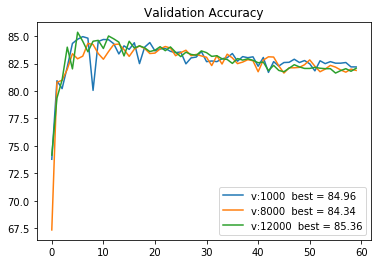

In [206]:
# plt.plot(a['uni_bi_tri_gram'],label = 'v:1000'+'  best = %s'%max(a['uni_bi_tri_gram']))
# plt.plot(a['v8k'],label = 'v:8000'+'  best = %s'%max(a['v8k']))
# plt.plot(a['v12k'],label = 'v:12000'+'  best = %s'%max(a['v12k']))
# plt.legend()
# plt.title('Validation Accuracy')
# plt.savefig('v_valacc.png')

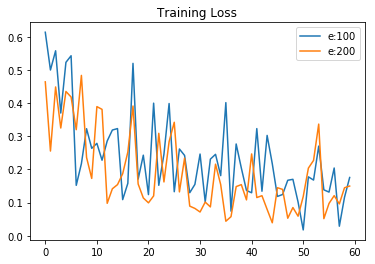

In [214]:
# plt.plot(b['v12k'],label = 'e:100')
# plt.plot(b['e200'],label = 'e:200')
# # plt.plot(b['v12k'],label = 'v:12000')
# plt.legend()
# plt.title('Training Loss')
# plt.savefig('e_trainloss.png')

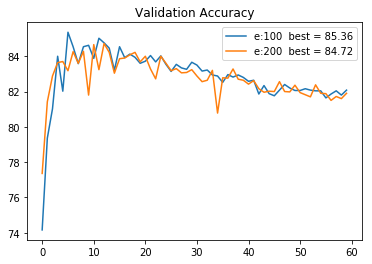

In [215]:
# plt.plot(a['v12k'],label = 'e:100'+'  best = %s'%max(a['v12k']))
# plt.plot(a['e200'],label = 'e:200'+'  best = %s'%max(a['e200']))
# # plt.plot(a['v12k'],label = 'v:12000'+'  best = %s'%max(a['v12k']))
# plt.legend()
# plt.title('Validation Accuracy')
# plt.savefig('e_valacc.png')

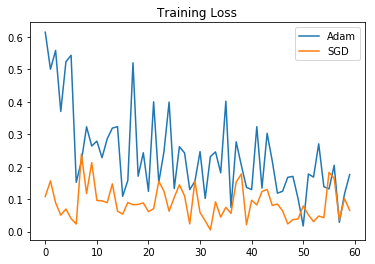

In [223]:
# plt.plot(b['v12k'],label = 'Adam')
# plt.plot(b['sgd'],label = 'SGD')
# # plt.plot(b['v12k'],label = 'v:12000')
# plt.legend()
# plt.title('Training Loss')
# plt.savefig('opt_trainloss.png')

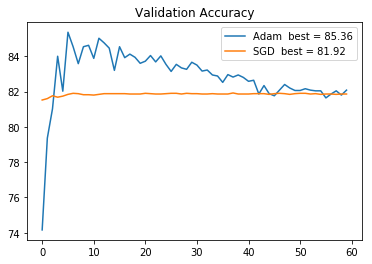

In [224]:
# plt.plot(a['v12k'],label = 'Adam'+'  best = %s'%max(a['v12k']))
# plt.plot(a['sgd'],label = 'SGD'+'  best = %s'%max(a['sgd']))
# # plt.plot(a['v12k'],label = 'v:12000'+'  best = %s'%max(a['v12k']))
# plt.legend()
# plt.title('Validation Accuracy')
# plt.savefig('opt_valacc.png')

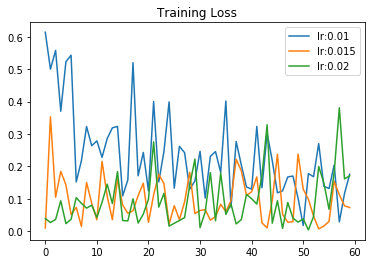

In [249]:
plt.plot(b['v12k'],label = 'lr:0.01')
plt.plot(b['lr015'],label = 'lr:0.015')

plt.plot(b['lr020'],label = 'lr:0.02')
plt.legend()
plt.title('Training Loss')
plt.savefig('lr_trainloss.png')

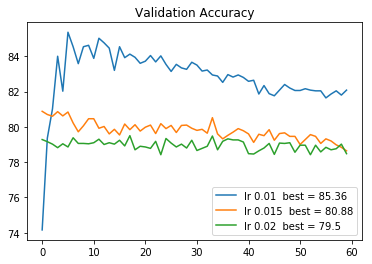

In [250]:
plt.plot(a['v12k'],label = 'lr 0.01'+'  best = %s'%max(a['v12k']))
plt.plot(a['lr015'],label = 'lr 0.015'+'  best = %s'%max(a['lr015']))
plt.plot(a['lr020'],label = 'lr 0.02'+'  best = %s'%max(a['lr020']))
# plt.plot(a['v12k'],label = 'v:12000'+'  best = %s'%max(a['v12k']))
plt.legend()
plt.title('Validation Accuracy')
plt.savefig('lr_valacc.png')

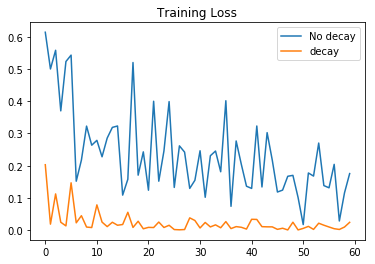

In [255]:
plt.plot(b['v12k'],label = 'No decay')
plt.plot(b['decay'],label = 'decay')

# plt.plot(b['lr020'],label = 'lr:0.02')
plt.legend()
plt.title('Training Loss')
plt.savefig('dc_trainloss.png')

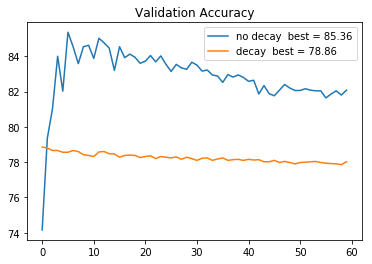

In [257]:
plt.plot(a['v12k'],label = 'no decay'+'  best = %s'%max(a['v12k']))
plt.plot(a['decay'],label = 'decay'+'  best = %s'%max(a['decay']))
# plt.plot(a['lr020'],label = 'lr 0.02'+'  best = %s'%max(a['lr020']))
# plt.plot(a['v12k'],label = 'v:12000'+'  best = %s'%max(a['v12k']))
plt.legend()
plt.title('Validation Accuracy')
plt.savefig('dc_valacc.png')

### Examples

In [279]:
model.eval()
index = []
for data, lengths, labels in val_loader:
    data_b, length_b, label_b = data, lengths, labels
    outputs = F.softmax(model(data_b, length_b), dim=1)
    pred = outputs.max(1, keepdim=True)[1]
    index += (pred.numpy() == labels.view_as(pred).numpy()).tolist()
    
correct = []
wrong = []
for i, val in enumerate(index):
    if val[0] == True:
        correct.append(i)
    else:
        wrong.append(i)

In [284]:

for i in [i for i in np.random.choice(correct, 5)]:
    print(val_data[i])
    print('')

*****WARNING, MAY CONTAIN SPOILERS WHICH WILL BE MORE ENTERTAINING THAN THIS TRIPE.**** <br /><br />Heres some good advise to anyone living in the U.K. Whenever Channel 5 has an old 80's comedy on late at night, read a book instead. I am currently in the process of recovering from a seizure, due to reading some of the comments on this film on here. I am actually shocked at the fact that someone actually said this film was realistic! All I can say is thank god the Cold War never escalated or else we might as well have given the Commie's our borders... I found this film dire in the utmost pretence, maybe it is just my British perception of what makes a film funny, who knows? But in all aspects, this film is not just awful, its teeth grindingly terrible.<br /><br />I've never been a fan of Bill Murray, and its rubbish like this that justify my feelings towards him. Don't get me wrong, I loved Ghostbuster's, which was made only three years after this film. But this just sums Bill Murray up

In [283]:
for i in [i for i in np.random.choice(wrong, 3)]:
    print(val_data[i])
    print('')

Oh, this is such a glorious musical. There's a bit of miscasting -- Frank Sinatra is sorely miscast as the Jewish Nathan Detroit, though it only becomes evident on "Sue Me", which is a distinctly Jewish song. Sadly, the filmmakers decided to cut out one of the best songs from the show, "Marry the Man Today", and replaced it with an inferior Sinatra showpiece. With these two flaws in mind, the movie is otherwise magnificent. Jean Simmons shines as Sarah Brown. Marlon Brando can't sing worth beans, but pulls it off anyway. Stubby Kaye wonderfully reprises his Broadway role (it was written for him). Damon Runyon's language and pacing and humor come through quite well. This is on my see-it-every-chance-I-get list.

I am not sure who is writing these<br /><br />glowing reviews for this movie but trust me it STKINKS. I have seen hundreds of horror films and slasher flicks and this one is LAME it is only about 80min long and believe me that is all I could take. Plot is terrible, acting is eve